In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.cluster import KMeans
from skimage import morphology, measure

In [3]:
images_folder = r'maskirane_slike'

slike = [
    'Breast_MRI_002_im_064_filt.png',
    'Breast_MRI_009_im_079_filt.png',
]

images = []
for file in slike:
    path = os.path.join(images_folder, file)
    if os.path.exists(path):
        img = Image.open(path)
        images.append(img)
    else:
        print(f"Fajl {file} ne postoji u folderu.")

print(f"Učitano {len(images)} slika.")

Učitano 2 slika.


In [30]:
from skimage import measure, morphology

def maske_za_dojke(img_):
    # Normalizacija
    img = cv2.normalize(img_, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # KMeans sa 3 klastera
    X = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
    kmeans.fit(X)

    labels = kmeans.labels_.reshape(img.shape)

    # Nađi klaster koji zauzima najveću površinu 
    cluster_sizes = [np.sum(labels == i) for i in range(3)] 
    selected_cluster = np.argmax(cluster_sizes) # najveći klaster

    # Nađi intenzitete po klasterima
    #cluster_means = [np.mean(img[labels == i]) for i in range(3)]

    # Pretpostavka: dojka = srednji intenzitet (ne najtamniji, ne najsvetliji)
    #sorted_clusters = np.argsort(cluster_means)   # [najtam., srednji, najsvetl.]
    #selected_cluster = sorted_clusters[1]         # biramo srednji

    # Kreiraj masku za taj klaster (dojke = belo)
    mask = (labels == selected_cluster).astype(np.uint8)
    if mask.sum() > 0.8 * mask.size: 
        mask = 1 - mask

    mask_closed = morphology.closing(mask, morphology.disk(15)) 
    mask_final = morphology.erosion(mask_closed, morphology.disk(3))
    #mask_final = morphology.opening(mask_closed, morphology.disk(3))
    return mask_final


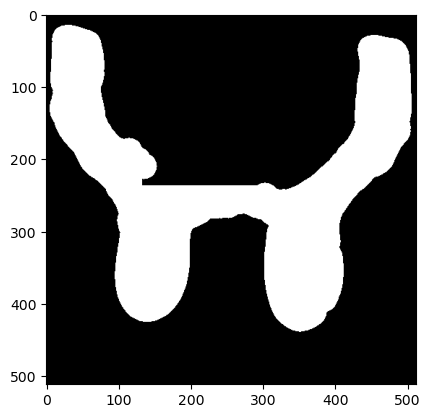

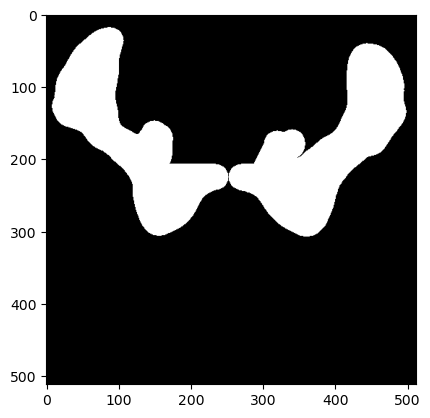

In [32]:
images_np = [np.array(img.convert('L')).astype(np.uint8) for img in images]

for img in images_np:
    mask = maske_za_dojke(img)
    plt.imshow(1-mask, cmap='gray')  # invertujemo masku
    plt.show()

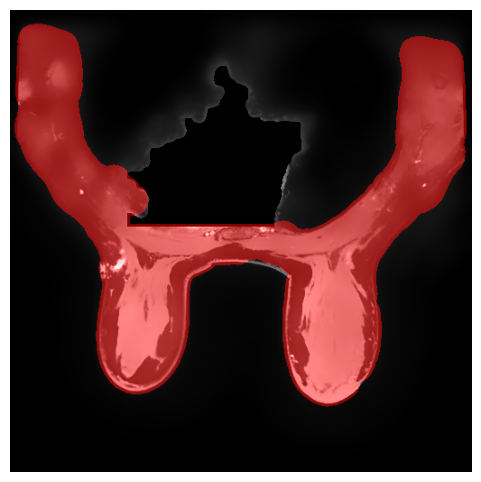

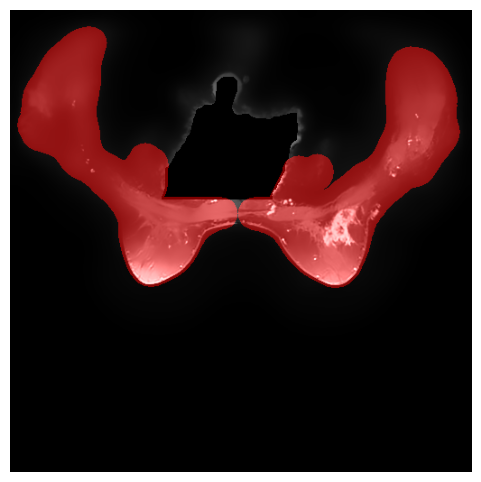

In [33]:
for orig_img, img in zip(images, images_np):

    mask = maske_za_dojke(img)
    mask_inv = 1 - mask

    orig_rgb = np.array(orig_img.convert('RGB'))

    color_mask = np.zeros_like(orig_rgb)
    color_mask[..., 0] = mask_inv * 255  

    alpha = 0.5  # providnost maske
    overlay = cv2.addWeighted(orig_rgb, 1, color_mask, alpha, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()